# Lesson 6.06 Generalized Linear Models

## Objectives
*After this lesson, students will be able to:*

1. Describe generalized linear models.
2. Fit Poisson and Gamma regression models in `statsmodels`.
3. Interpret coefficients from Poisson and Gamma regression models.

### Recall: The Anatomy of a GLM
GLMs are made up of three components:
* **Random component** - Distributional assumption of $y_i$.
* **Systematic component** (or **linear component**) - The choice of _x_-variables in your model.
* **Link function** - The function that connects systematic and random components. Must input the range of possible values of $\mu_i$ and output $\mathbb{R}$.

While there are many kinds of GLMs out there, today we'll focus on two new commonly used ones:
* **Poisson regression**
* **Gamma regression**

## The `statsmodels` API

We will use the `statsmodels` API to explore GLMs in Python.  (`sklearn` does not have a robust implementation for GLMs.)  Documentation and examples for `statsmodels` can be found [here](http://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM).

Fitting GLMs in `statsmodels` will be as easy as using the `sm.GLM()` class and setting the three components.

## Poisson Regression

**When do we use it?** When we want to model something on the $\{0,1,2,\ldots\}$ range... like number of cars on through a toll road, number of objects sold or number of awards earned!

<img src="./images/poisson_model.png" alt="poisson_model" width="400"/>

#### Data
We'll rely on UCLA's IDRE module.  This one can be found [here](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

#### Data Description
_The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math._

1. `num_awards` is the outcome variable and indicates the number of awards earned by students at a high school in a year, math is a continuous predictor variable and represents students’ scores on their math final exam
2. `prog` is a categorical predictor variable with three levels indicating the type of program in which the students were enrolled. It is coded as 1 = “General”, 2 = “Academic” and 3 = “Vocational”. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [2]:
# Read in data.
award = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")

# Check first five rows.
award.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


Text(0, 0.5, 'Number of awards received')

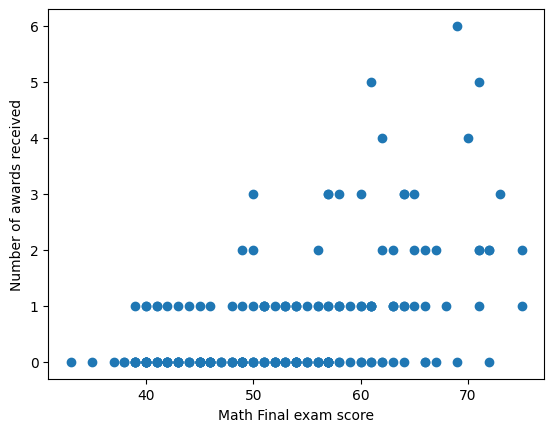

In [3]:
# Plot a scatterplot of math (x) vs. number of awards (y).
plt.scatter(award['math'], award['num_awards'])
plt.xlabel('Math Final exam score')
plt.ylabel('Number of awards received')

<Axes: title={'center': 'num_awards'}, xlabel='prog'>

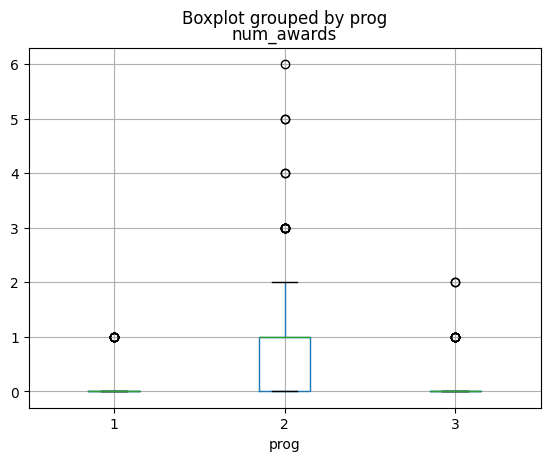

In [4]:
# Plot distribution of awards by program.
award.boxplot('num_awards', by='prog')

**What might we infer from this plot?**

- `prog` is definitely not linearly related to the number of awards one receives.
- `prog` looks like a categorical variable.

### Poisson GLM : modelling count data

![Poisson function](https://i.imgur.com/p5Y71Es.png)

1. Take y | x (awards given the features) to follow the Poisson distribution
2. log E[awards | features] follow the Poisson Distribution
3. natural parameter = parameter * features 

In [5]:
# Set up X.
award_dummy = pd.get_dummies(columns=['prog'], data=award, drop_first=True, dtype="int")

print(award_dummy.head())

    id  num_awards  math  prog_2  prog_3
0   45           0    41       0       1
1  108           0    41       0       0
2   15           0    44       0       1
3   67           0    42       0       1
4  153           0    40       0       1


In [6]:
poi_vars = ['prog_2', 'prog_3', 'math']
X = sm.add_constant(award_dummy[poi_vars]) 

# Set up y.
y = award['num_awards']

In [7]:
X

,const,prog_2,prog_3,math
0,1.0,0,1,41
1,1.0,0,0,41
2,1.0,0,1,44
3,1.0,0,1,42
4,1.0,0,1,40
...,...,...,...,...
195,1.0,1,0,71
196,1.0,0,1,75
197,1.0,1,0,71
198,1.0,1,0,72


In [8]:
# Fit model.
glm_poi = sm.GLM(
    y, X,
    family=sm.families.Poisson(link = sm.families.links.log())
).fit()

# In statsmodels, y is the first argument.
# In statsmodels, X is the second argument.

/home/leecming/dsif-data/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [9]:
# Generate summary of model.
glm_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -182.75
Date:                Sun, 23 Jun 2024   Deviance:                       189.45
Time:                        06:20:59   Pearson chi2:                     212.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3881
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2471      0.658     -7.969      0.000      -6.538      -3.957
prog_2         1.0839      0.358      3.025      0.002       0.382       1.786
prog_3         0.3698      0.441      0.838      0.402      -0.495       1.234
math           0.0702      0.011      6.619      0.000       0.049       0.091
==============================================================================
"""

#### Interpreting Model Performance

- The log-likelihood value can be used to measure the goodness of fit for a model. 
- The higher the value of the log-likelihood, the better a model fits a dataset.
- The log-likelihood value for a given model can range from negative infinity to positive infinity. 
- The actual log-likelihood value for a given model on its own offers little value and should be used for comparing two or more models.

#### Interpreting Poisson Coefficients

Because of the log link function, we interpret a one-unit increase in $X_i$ as follows:

"As $X_i$ increases by 1, I expect $Y$ to increase by a factor of $e^{\beta_1}$."

In [10]:
# apply numpy exponentiate on math X-variable
np.exp(0.0702)

np.float64(1.072722704342061)

In [11]:
# apply numpy exponentiate on prog_2  X-variable
np.exp(1.0839)

np.float64(2.9561862247436466)

**Example**: All else held equal, for a one-unit increase in `math`, I expect to win $e^{0.0702} \approx 1.07$ times as many awards.

**How would you interpret `prog_2`?**
- If you are in Program 2, I expect to win $e^{1.0839} \approx 3$ times as many awards as if you were in Program 1, holding all else constant.

## Gamma Regression GLM

**When do we use it?** When we want to model something on the $[0,\infty)$ range... like time until some event occurs!

### The Data
**Data Description:** _“Hurn, et al. (1945) published data on the clotting time of blood, giving clotting time in seconds for normal plasma diluted to nine different percentage concentrations with prothrombin-free plasma; clotting was induced by two lots of thromboplastin.” [McCullagh and Nelder](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf)_


![Gamma function](https://i.imgur.com/p5Y71Es.png)

1. Take y | x (awards given the features) to follow the Poisson distribution
2. log E[awards | features] follow the Poisson Distribution
3. natural parameter = parameter * features 

In [12]:
# Read data in.
clot = pd.read_csv("../datasets/clotting.csv", index_col="index")

In [13]:
# Check the first five rows.
clot.head()

,plasma_pct,clot_time,lot
index,,,
1,5,118,1
2,10,58,1
3,15,42,1
4,20,35,1
5,30,27,1


<Axes: title={'center': 'clot_time'}, xlabel='lot'>

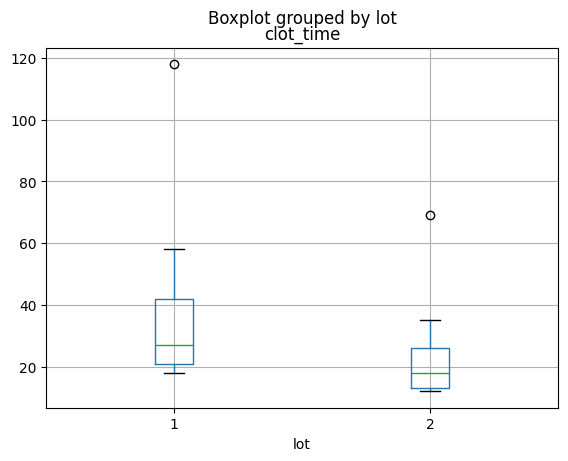

In [14]:
# Generate a boxplot of clot_time group by lot.
clot.boxplot('clot_time', by = 'lot')

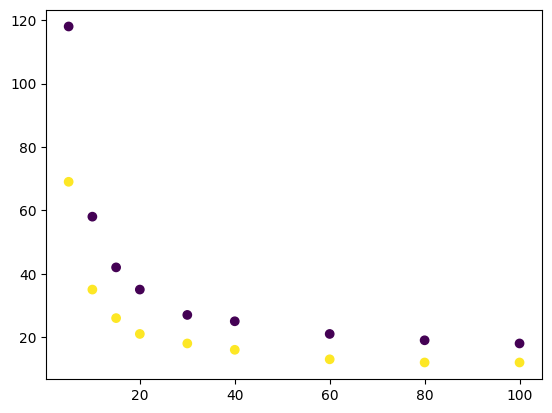

In [15]:
# Plot plasma_pct against clot_time.
# Color code the plots based on the lot type i.e. 1 or 2
plt.scatter(clot['plasma_pct'], clot['clot_time'], c=clot['lot'])

In [16]:
# Take the Log base of plasma_pct.
clot['plasma_pct_log'] = np.log(clot['plasma_pct'])

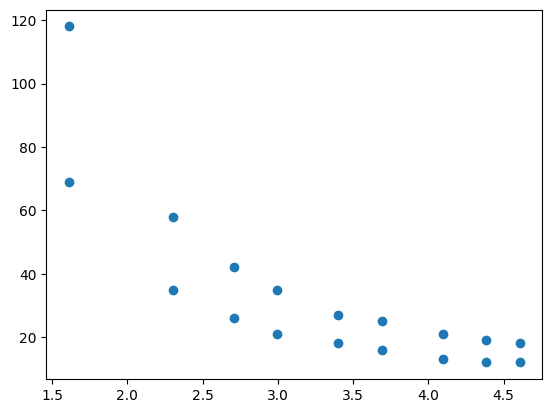

In [17]:
# Plot our new variable against clot_time.
plt.scatter(clot['plasma_pct_log'], clot['clot_time'])

In [18]:
# Set up X inclusive of an additional column for constants
X = sm.add_constant(clot[['plasma_pct', 'lot']])

# Set up y.
y = clot['clot_time']

In [19]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
# Build Model
# Fit model.
# NOTE: For prediction purposes, the inverse link might actually be best (it's the "canonical link")
# but the log link allows us to interpret our coefficients.
gamma_model = sm.GLM(
    y_train, X_train,
    family=sm.families.Gamma(link = sm.families.links.log())
    # family = sm.families.Gamma(link = sm.families.links.inverse_power)
).fit()

# Make Predictions
gamma_model.predict(X_test)

/home/leecming/dsif-data/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


index
7    28.283853
4    53.979650
5    26.711929
3    58.521642
dtype: float64

In [21]:
# Generate summary of model.
gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              clot_time   No. Observations:                   14
Model:                            GLM   Df Residuals:                       11
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.16807
Method:                          IRLS   Log-Likelihood:                -51.128
Date:                Sun, 23 Jun 2024   Deviance:                       1.6707
Time:                        06:20:59   Pearson chi2:                     1.85
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9031
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8537      0.395     12.279      0.000       4.079       5.628
plasma_pct    -0.0162      0.003     -4.994      0.000      -0.022      -0.010
lot           -0.5419      0.222     -2.445      0.014      -0.976      -0.108
==============================================================================
"""

#### Interpreting Model Performance

- The log-likelihood value can be used to measure the goodness of fit for a model. 
- The higher the value of the log-likelihood, the better a model fits a dataset.
- The log-likelihood value for a given model can range from negative infinity to positive infinity. 
- The actual log-likelihood value for a given model on its own offers little value and should be used for comparing two or more models.

#### Interpreting Gamma Coefficients

Because of the log link function (again!), we interpret a one-unit increase in $X_i$ as follows:

"As $X_i$ increases by 1, I expect $Y$ to increase by a factor of $e^{\beta_1}$."

In [22]:
# Exponentiate our coefficient.
np.exp(-0.0162)

np.float64(0.9839305142725083)

**How would you interpret plasma_pct?**

1. For a one-unit increase in `plasma_pct`, I expect the blood will take $e^{-0.0156} \approx 98\%$ as much time to clot, holding `lot` constant.
    
2. Another way to think about this is, for a one-unit increase in `plasma_pct`, I expect the blood will clot about $2\%$ faster, holding `lot` constant.

## Summary
Today, we:
* Learned how to generalize two models we already knew (linear and logistic regression) into a borader category of models (GLMs)
* Refamiliarized ourselves with the `statsmodels` API
* Learned the components of GLMs, and how to customize them with `statsmodels`:
    - Systematic/linear component, ie, our choice of x-variables
    - Link function - a function we choose to "bend" our response to our y-variable
    - Random component - The distribution that represents the data-generation process for our y-variable
* Two new linear models:
    - **Poisson regression** - For when your y-variable is Poisson distributed. Most commonly used for _count data_.
        - e.g. Predicting how many children a couple will have based on age and income
    - **Gamma regression** - For when your y-variable is Gamma distributed. Most commonly used for _waiting-time data_.
        - e.g. Predicting how long your phone's battery will last based on screentime use